# StraitFlux

We present a tool for easy and accurate computation of **oceanic transports of volume, heat, salinity and ice**, as well as **crosssections** of the vertical plane of **currents, temperature and salinity**. StraitFlux works on various curvilinear modelling grids (+ regular grids), independant of the exact curvature, the number of poles and the used Arakawa partition. More information may be found in Winkelbauer et al. (2023).<br>
StraitFlux is available on github, zenodo and via pypi.<br>
Here, we give examples of transport calculations using the CanESM5 CMIP6 model, which can be downloades via ESGF (e.g. https://esgf.dwd.de/search/cmip6-dwd/).

To obtain the data needed for this notebook you may follow the `Download.ipynb` script.

Due to a bug in `esmpy` the import of`xesmf` may fail as the path to the ESMFMKFILE environment variable can't be found. Therefore, it may be needed to specify the path manually (see https://github.com/conda-forge/esmf-feedstock/issues/91) . <br>
You may find the path of the ESMFMKFILE by running the following two lines in your shell in an environment which contains esmpy (e.g. the environment you just installed for `StraitFlux`):<br>
`python -c "import esmpy"`<br>
`echo $ESMFMKFILE`

The output should give you the path to your esmf file looking something like:
`%env ESMFMKFILE=/path/to/environments/envs/ENVNAME/lib/esmf.mk`

In [1]:
%env ESMFMKFILE=/home/swd/jupyterhub/alpha/envs/cda2023/lib/esmf.mk

env: ESMFMKFILE=/home/swd/jupyterhub/alpha/envs/cda2023/lib/esmf.mk


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import xesmf as xe
import matplotlib.pyplot as plt
import xarray as xa
import numpy as np

In [4]:
from StraitFlux import masterscript_line as master
from StraitFlux import masterscript_cross as master2

## Example 1: Transports through a predefined Strait

### Calculate transport(s) - Line integration:
We will start with net integrated transports using the line integration method (`master.transports`).

In [5]:
# Let's check the details of the transport function: 
help(master.transports)

Help on function transports in module StraitFlux.masterscript_line:

transports(product, strait, model, time_start, time_end, file_u, file_v, file_t, file_z, coords=0, set_latlon=False, lon_p=0, lat_p=0, file_s='', file_sic='', file_sit='', Arakawa='', rho=1026, cp=3996, Tref=0, path_save='', path_indices='', path_mesh='', saving=True)
    Calculation of Transports using line integration
    
    INPUT Parameters:
    product (str): volume, heat, salt or ice
    strait (str): desired oceanic strait, either pre-defined from indices file or new
    model (str): desired CMIP6 model or reanalysis
    time_start (str or int): starting year
    time_end (str or int): ending year
    file_u (str): path + filename(s) of u field(s); use ice velocities (ui) for ice transports; (multiple files possible, use *; must be possible to combine files over time coordinate)
    file_v (str): path + filename(s) of v field(s); use ice velocities (vi) for ice transports; (multiple files possible, use *)
    

#### So first we need to define the INPUT parameters:
Define the used model (e.g. CanESM5), the type of transport (volume, heat, salinity and ice), the strait, time range and a path for the output data.

The strait may either be chosen from a predefined list of straits in the indices.py file, or if not predefined it may be defined using a tuple of coordinates (latitude_start,longitude_start,latitude_end,longitude_end).

In [4]:
model='CanESM5'
product = 'volume'
strait='Fram' #let's first calculate transports for the predefined Fram Strait; check `indices.py` for exact coordinates
time_start='2001-01'
time_end='2010-12'
path='Examples/' # path to save data
import os
os.makedirs(path,exist_ok=True)
path_data='YOUR_PATH/' #adapt to your data path (e.g. specified in download.ipynb)!

In [7]:
#All fields have to include the native lat/lon coordinates!
file_t=path_data+'thetao*r1i1p1f1*2001*'
file_u=path_data+'uo*r1i1p1f1*2001*'
file_v=path_data+'vo*r1i1p1f1*2001*'
file_z=path_data+'thkcello*r1i1p1f1*'

When all INPUT parameters are defined we may run our first calculation.

Note: the first calculation for every model may take a few seconds longer, as horizontal meshes are calculated and the Arakawa partition is determined. However, this is only done once per model and saved for future calculations.
Similarily the indices for every strait have to be calculated for every model and are than saved for fututre calculations.

In [8]:
transport = master.transports(product,strait,model,time_start,time_end,file_u,file_v,file_t,file_z,path_save=path,path_indices=path,path_mesh=path)

read t, u and v fields
load t, u and v fields
[########################################] | 100% Completed | 4.07 sms
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 102.27 ms
calc dz at cell faces


100%|██████████| 15/15 [00:00<00:00, 4203.55it/s]

 ...calculating transport
calc u
calc v
calc line


The calculation for 10 years of monthly data takes about 20-30 seconds as indices, Arakawa-partition and horizontal meshes have to be calculated.

You'll notice that repeating the calculation for another time period or product will take considerably less time (if all paths are set properly!). So let's retry with heat transports:

In [9]:
product='heat'
transportH = master.transports(product,strait,model,time_start,time_end,file_u,file_v,file_t,file_z,path_save=path,path_indices=path,path_mesh=path)

read t, u and v fields
load t, u and v fields
[########################################] | 100% Completed | 3.66 sms
[########################################] | 100% Completed | 3.57 sms
[########################################] | 100% Completed | 3.46 sms
[########################################] | 100% Completed | 102.46 ms
calc dz at cell faces


100%|██████████| 15/15 [00:00<00:00, 6229.78it/s]

 ...calculating transport
rolling T
calc u
calc v
calc line


Performing the second calculation is considerably faster (about 5 s).

Let's Plot the Data:

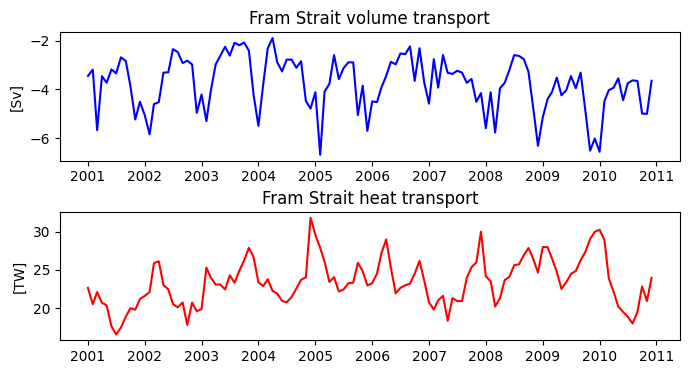

In [10]:
fig,axs=plt.subplots(2,1,figsize=(8,4))
ax=axs[0]
ax.plot(xa.date_range(time_start,time_end,freq='MS'),transport['CanESM5']/1e6,c='b')
ax.set_ylabel('[Sv]')
ax.set_title('Fram Strait volume transport')
ax=axs[1]
ax.plot(xa.date_range(time_start,time_end,freq='MS'),transportH['CanESM5']/1e12,c='r')
ax.set_ylabel('[TW]')
ax.set_title('Fram Strait heat transport')

plt.subplots_adjust(hspace=0.4)

### Calculate transport(s) - Vector Projection:
Using the `vel_projection` function from masterscript_cross it is possible to visualize currents flowing through the desired strait

In [11]:
uv=master2.vel_projection(strait,model,time_start,time_end,file_u,file_v,file_t,file_z,path_save=path,path_mesh=path,path_indices=path)

read t, u and v fields
load t, u and v fields
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 3.51 sms
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 102.41 ms
calc dz at cell faces


100%|██████████| 17/17 [00:00<00:00, 4071.67it/s]

calculating regridder
0.03238511085510254
0.08681392669677734
regridding


0.6923203468322754


Again the first calculation will take a couple seconds longer, as all parameters (indices, projection vectors, etc.) have to be calculated

We can further use the function `TS_interp` from `masterscript_cross` to calculated temperature and salinity crosssections 

In [12]:
help(master2.TS_interp)

Help on function TS_interp in module StraitFlux.masterscript_cross:

TS_interp(product, strait, model, time_start, time_end, file_u, file_t, file_s='', coords=0, set_latlon=False, lat_p=0, lon_p=0, path_save='', path_indices='', path_mesh='', saving=True)
    This function calculates the u/v crossection by projecting the vectors onto the strait 
    by multiplying with the amount of the vector going through the strait and
    regridding the values onto the T-proj points on the reference line 
    
    INPUT Parameters:
    product (str): T or S
    strait (str): desired oceanic strait, either pre-defined from indices file or new
    model (str): desired CMIP6 model or reanalysis
    time_start (str or int): starting year
    time_end (str or int): ending year
    file_u (str): path + filename(s) of u field(s); use ice velocities (ui) for ice transports; (multiple files possible, use *; must be possible to combine files over time coordinate)
    file_t (str): path + filename(s) of tempe

In [13]:
T=master2.TS_interp('T',strait,model,time_start,time_end,file_u,file_t,path_save=path,path_mesh=path,path_indices=path)

read t and/or s fields
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 102.34 ms
calculating regridder


100%|██████████| 45/45 [00:00<00:00, 170.59it/s]


regridding


In [14]:
file_s=path_data+'so*r1i1p1f1*2001*'

In [15]:
S=master2.TS_interp('S',strait,model,time_start,time_end,file_u,file_t,file_s=file_s,path_save=path,path_mesh=path,path_indices=path)

read t and/or s fields
[########################################] | 100% Completed | 5.45 sms
[########################################] | 100% Completed | 103.45 ms
calculating regridder


100%|██████████| 45/45 [00:00<00:00, 170.15it/s]


regridding


Let's Plot all crosssections:

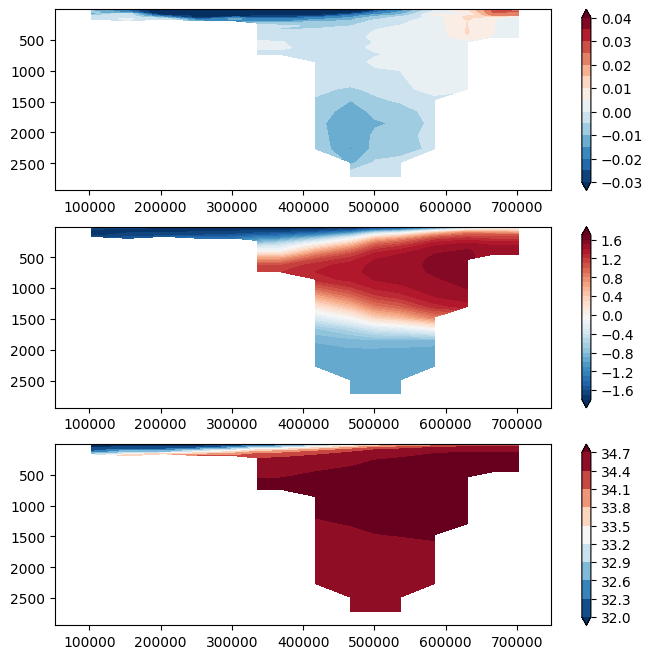

In [16]:
fig,axs=plt.subplots(3,1,figsize=(8,8))
ax=axs[0]
a=ax.contourf(uv.x,uv.depth.sel(depth=slice(0,3000)),uv.uv.mean('time').sel(depth=slice(0,3000)),cmap='RdBu_r',levels=np.arange(-0.03,0.04,0.005),extend='both')
plt.colorbar(a)
ax.invert_yaxis()

ax=axs[1]
a=ax.contourf(T.x,T.depth.sel(depth=slice(0,3000)),T.T.mean('time').sel(depth=slice(0,3000)),cmap='RdBu_r',levels=np.arange(-1.8,1.8,0.1),extend='both')
plt.colorbar(a)
ax.invert_yaxis()

ax=axs[2]
a=ax.contourf(S.x,S.depth.sel(depth=slice(0,3000)),S.S.mean('time').sel(depth=slice(0,3000)),cmap='RdBu_r',levels=np.arange(32,35,0.3),extend='both')
plt.colorbar(a)
ax.invert_yaxis()

The variables dx_int and dz_int in the uv Dataset may be used to obtain integrated transports again:

Comparisons of the line integration and the vector projection method show only small deviations between the two methods:

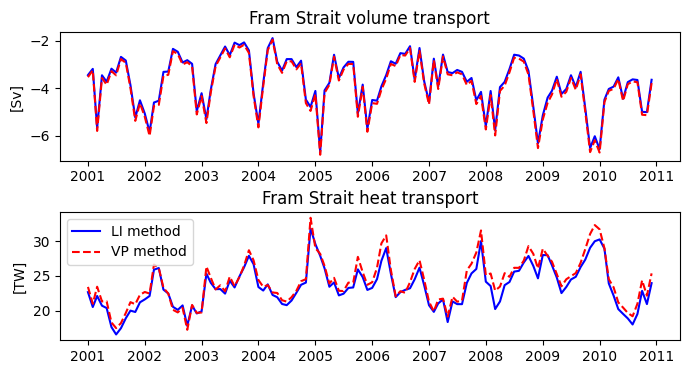

In [17]:
fig,axs=plt.subplots(2,1,figsize=(8,4))
ax=axs[0]
ax.plot(xa.date_range(time_start,time_end,freq='MS'),transport['CanESM5']/1e6,c='b',label='LI method')
ax.plot(xa.date_range(time_start,time_end,freq='MS'),(uv.uv*uv.dx_int*uv.dz_int).sum(axis=(1,2))/1e6,c='r',ls='--',label='VP method')
ax.set_ylabel('[Sv]')
ax.set_title('Fram Strait volume transport')
ax=axs[1]
ax.plot(xa.date_range(time_start,time_end,freq='MS'),transportH['CanESM5']/1e12,c='b',label='LI method')
ax.plot(xa.date_range(time_start,time_end,freq='MS'),(uv.uv*uv.dx_int*uv.dz_int*T.T.values*1026*3996).sum(axis=(1,2))/1e12,c='r',ls='--',label='VP method')
ax.set_ylabel('[TW]')
ax.set_title('Fram Strait heat transport')
ax.legend()
plt.subplots_adjust(hspace=0.4)

## Example 2: Define new coordinates

Let's calculate volume transports for a random strait through the Atlantic by supplying the `coords` parameter.

In [18]:
model='CanESM5'
product = 'volume'
time_start='2001-01'
time_end='2010-12'
path='Examples/'

In [19]:
path_data='YOUR_PATH/' #adapt to your data path (e.g. specified in download.ipynb)!
file_t=path_data+'thetao*r1i1p1f1*2001*'
file_u=path_data+'uo*r1i1p1f1*2001*'
file_v=path_data+'vo*r1i1p1f1*2001*'
file_z=path_data+'thkcello*r1i1p1f1*'

In [20]:
strait='Atlantic1' #let's call our strait Atlantic1
coords=(52,-57,48.5,-3.5) #defining coordinates as tuple (latitude_start,longitude_start,latitude_end,longitude_end); here we go from Newfoundland across the Atlantic to France.

In [21]:
transport = master.transports(product,strait,model,time_start,time_end,file_u,file_v,file_t,file_z,path_save=path,path_indices=path,path_mesh=path,coords=coords) # note the coords parameter!

read t, u and v fields
load t, u and v fields
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 3.46 sms
[########################################] | 100% Completed | 3.58 sms
[########################################] | 100% Completed | 102.87 ms
calc dz at cell faces


100%|██████████| 53/53 [00:00<00:00, 6889.12it/s]

 ...calculating transport
calc u


calc v
calc line


In [22]:
transportH = master.transports('heat',strait,model,time_start,time_end,file_u,file_v,file_t,file_z,path_save=path,path_indices=path,path_mesh=path,coords=coords) # note the coords parameter!

read t, u and v fields
load t, u and v fields
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 3.37 sms
[########################################] | 100% Completed | 3.37 sms
[########################################] | 100% Completed | 102.19 ms
calc dz at cell faces


100%|██████████| 53/53 [00:00<00:00, 6600.50it/s]

 ...calculating transport
rolling T


calc u
calc v
calc line


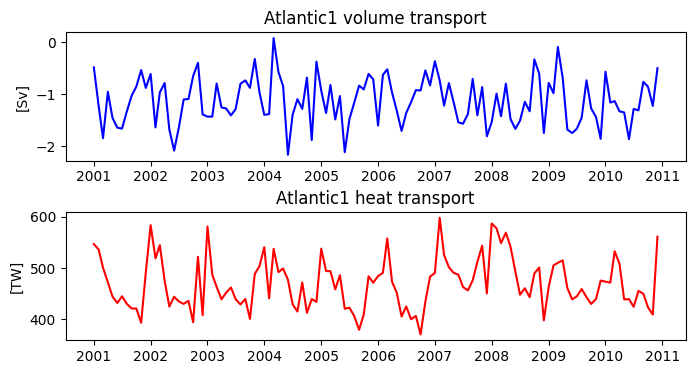

In [23]:
fig,axs=plt.subplots(2,1,figsize=(8,4))
ax=axs[0]
ax.plot(xa.date_range(time_start,time_end,freq='MS'),transport['CanESM5']/1e6,c='b')
ax.set_ylabel('[Sv]')
ax.set_title('Atlantic1 volume transport')
ax=axs[1]
ax.plot(xa.date_range(time_start,time_end,freq='MS'),transportH['CanESM5']/1e12,c='r')
ax.set_ylabel('[TW]')
ax.set_title('Atlantic1 heat transport')

plt.subplots_adjust(hspace=0.4)

In [24]:
uv=master2.vel_projection(strait,model,time_start,time_end,file_u,file_v,file_t,file_z,path_save=path,path_mesh=path,path_indices=path,coords=coords)

read t, u and v fields
load t, u and v fields
[########################################] | 100% Completed | 3.66 sms
[########################################] | 100% Completed | 3.46 sms
[########################################] | 100% Completed | 3.46 sms
[########################################] | 100% Completed | 102.64 ms
calc dz at cell faces


100%|██████████| 55/55 [00:00<00:00, 5667.70it/s]

calculating regridder
0.06474852561950684


0.2972748279571533
regridding
1.760094165802002


In [25]:
T=master2.TS_interp('T',strait,model,time_start,time_end,file_u,file_t,path_save=path,path_mesh=path,path_indices=path,coords=coords)

read t and/or s fields
[########################################] | 100% Completed | 3.56 sms
[########################################] | 100% Completed | 102.22 ms
calculating regridder


100%|██████████| 45/45 [00:02<00:00, 16.90it/s]


regridding


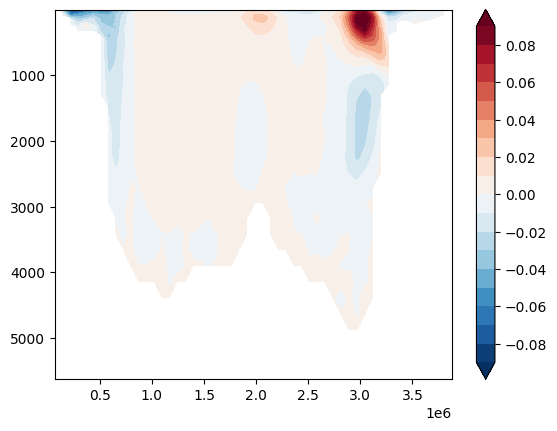

In [26]:
plt.contourf(uv.x,uv.depth[:50],uv.uv.mean('time'),cmap='RdBu_r',levels=np.arange(-0.09,0.1,0.01),extend='both')
plt.colorbar()
plt.gca().invert_yaxis()

Using the crosssection we could now e.g. also calculate the Meridional Overturning Streamfunction:

Text(0.5, 0, 'mstf [SV]')

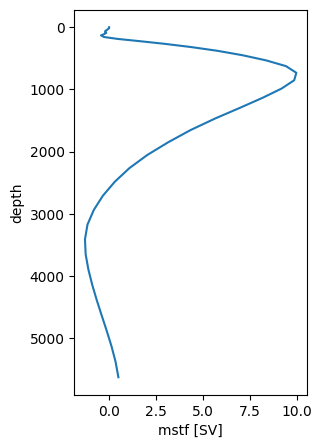

In [27]:
plt.figure(figsize=(3,5))
plt.plot(((uv.uv*uv.dx_int*uv.dz_int).sum(axis=2)[:,::-1].cumsum('depth')/-1e6).mean('time'),uv.depth)
plt.gca().invert_yaxis()
plt.ylabel('depth')
plt.xlabel('mstf [SV]')

## Example 2.1: Define new coordinates II
Alternatively we could set `set_latlon=True` and supply lists of latitude and longitude coordinates via `lat_p=` and `lon_p=`.

This enables us to also supply non-linear lines through the ocean, by e.g. following a mooring line.

Again it is important to ensure that the spacing between the lat/lon points of the strait is fine enough (e.g. spacing of 0.1° for a 0.25° model as the spacing resolution gets finer towards the artificial poles..)

## Example 3: Use loops to save memory (needed for higher resolution models!)

In [28]:
# We can supress the function outputs using e.g. contextlib (not necessary!!):
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

In [29]:
@contextmanager
def suppress_stdout_stderr():
    "stdout and stderr are redirected to devnull"
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)
#see: https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions

In [30]:
model='CanESM5'
product = 'volume'
#time_start='2001-01'
#time_end='2010-12'
path='Examples/'

In [31]:
path_data='YOUR_PATH/' #adapt to your data path (e.g. specified in download.ipynb)!
file_t=path_data+'thetao*r1i1p1f1*2001*'
file_u=path_data+'uo*r1i1p1f1*2001*'
file_v=path_data+'vo*r1i1p1f1*2001*'
file_z=path_data+'thkcello*r1i1p1f1*'

In [32]:
years=np.arange(2001,2011,1)

In [33]:
transports={}
for i in years:
    time_start=str(i)+'-01'
    time_end=str(i)+'-12'
    print(time_start,time_end)
    with suppress_stdout_stderr():
        transports[i]=master.transports(product,strait,model,time_start,time_end,file_u,file_v,file_t,file_z,path_save=path,path_indices=path,path_mesh=path,coords=coords)    

2001-01 2001-12
2002-01 2002-12
2003-01 2003-12
2004-01 2004-12
2005-01 2005-12
2006-01 2006-12
2007-01 2007-12
2008-01 2008-12
2009-01 2009-12
2010-01 2010-12


In [34]:
transports=xa.concat(transports.values(),dim='time')

In [35]:
transports

<xarray.Dataset>
Dimensions:  (time: 120)
Coordinates:
  * time     (time) object 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Data variables:
    CanESM5  (time) float64 -4.821e+05 -1.224e+06 ... -1.224e+06 -4.983e+05

## Example 4: Reanalyses data
Use the `Download.ipynb` to download the needed data files (x-velocity, y-velocity, temperature, cell thickness) for the year 1993

In [36]:
model='GLORYS2V4'
product = 'volume'
strait='Fram'
# define the data paths:
path='Examples/'

In [37]:
time_start='1993-01'
time_end='1993-12'

In [38]:
path_data='YOUR_PATH/' #adapt to your data path (e.g. specified in download.ipynb)!
file_t=path_data+'GLORYS2V4_thetao_1993-*'
file_u=path_data+'GLORYS2V4_uo_1993-*'
file_v=path_data+'GLORYS2V4_vo_1993-*'
file_z=path_data+'mesh_e3t_field*'

In [39]:
transport = master.transports(product,strait,model,time_start,time_end,file_u,file_v,file_t,file_z,path_save=path,path_indices=path,path_mesh=path)    

read t, u and v fields
correcting lat/lon dimensions
load t, u and v fields
[########################################] | 100% Completed | 947.49 ms
[########################################] | 100% Completed | 489.01 ms
[########################################] | 100% Completed | 572.02 ms
[########################################] | 100% Completed | 102.20 ms
calc dz at cell faces


100%|██████████| 54/54 [00:00<00:00, 4332.88it/s]

 ...calculating transport
calc u
calc v
calc line


In [40]:
uv=master2.vel_projection(strait,model,time_start,time_end,file_u,file_v,file_t,file_z,path_save=path,path_mesh=path,path_indices=path)

read t, u and v fields
correcting lat/lon dimensions
load t, u and v fields
[########################################] | 100% Completed | 424.91 ms
[########################################] | 100% Completed | 7.32 sms
[########################################] | 100% Completed | 7.69 sms
[########################################] | 100% Completed | 809.72 ms
calc dz at cell faces


100%|██████████| 56/56 [00:00<00:00, 3985.97it/s]

calculating regridder
0.14713501930236816


0.2433938980102539
regridding
0.507270097732544


In [41]:
T=master2.TS_interp('T',strait,model,time_start,time_end,file_u,file_t,path_save=path,path_mesh=path,path_indices=path)

read t and/or s fields
[########################################] | 100% Completed | 8.81 sms
[########################################] | 100% Completed | 911.48 ms
calculating regridder


100%|██████████| 75/75 [00:05<00:00, 13.17it/s]


regridding


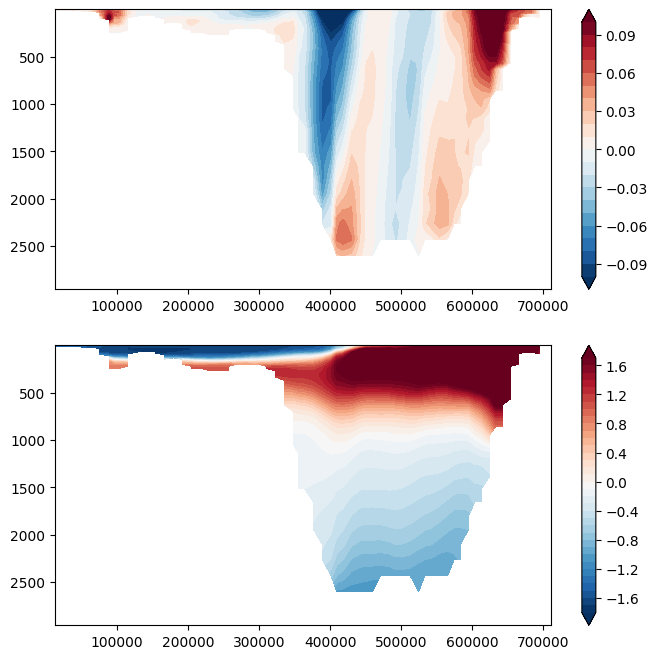

In [42]:
fig,axs=plt.subplots(2,1,figsize=(8,8))
ax=axs[0]
a=ax.contourf(uv.x,uv.depth.sel(depth=slice(0,3000)),uv.uv.mean('time').sel(depth=slice(0,3000)),cmap='RdBu_r',levels=np.arange(-0.1,0.11,0.01),extend='both')
plt.colorbar(a)
ax.invert_yaxis()

ax=axs[1]
a=ax.contourf(T.x,T.depth.sel(depth=slice(0,3000)),T.T.mean('time').sel(depth=slice(0,3000)),cmap='RdBu_r',levels=np.arange(-1.8,1.8,0.1),extend='both')
plt.colorbar(a)
ax.invert_yaxis()

Text(0.5, 1.0, 'Fram Strait volume transport')

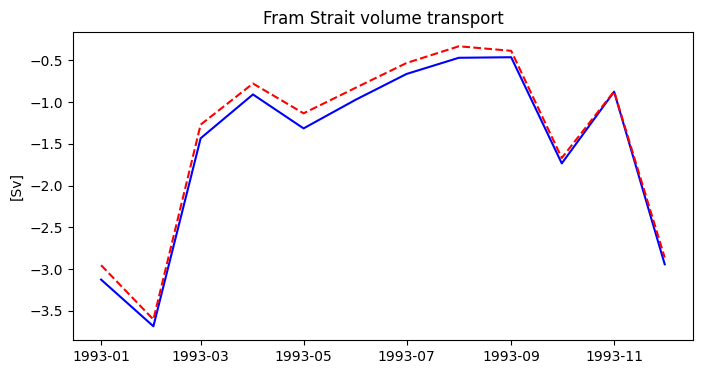

In [43]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(xa.date_range(time_start,time_end,freq='MS'),transport['GLORYS2V4']/1e6,c='b',label='LI method')
ax.plot(xa.date_range(time_start,time_end,freq='MS'),(uv.uv*uv.dx_int*uv.dz_int).sum(axis=(1,2))/1e6,c='r',ls='--',label='VP method')
ax.set_ylabel('[Sv]')
ax.set_title('Fram Strait volume transport')